Original RGB Pixel: [255 128  64]
Normalized RGB Pixel: [1.         0.50196078 0.25098039]
Converted HSI Pixel: [19.21798727  0.5704698   0.58431373]
Reconstructed RGB Pixel: [254 128  64]


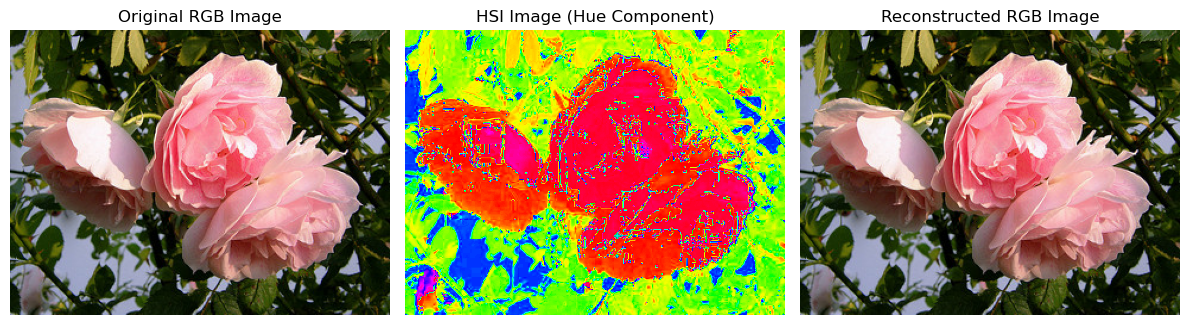

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the RGB to HSI conversion function
def rgb_to_hsi(image):
    """
    Converts an RGB image to HSI color space.
    HSI components:
      - Hue: Determines the type of color.
      - Saturation: Represents the color intensity.
      - Intensity: Represents the brightness.
    """
    # Normalize the image to [0, 1]
    normalized_rgb = image / 255.0
    R, G, B = normalized_rgb[:, :, 0], normalized_rgb[:, :, 1], normalized_rgb[:, :, 2]

    # Compute Intensity (I)
    I = (R + G + B) / 3

    # Compute Saturation (S)
    min_RGB = np.minimum(np.minimum(R, G), B)
    S = np.zeros_like(I)  # Initialize S to zeros
    non_zero_I = I > 0  # Mask for non-zero intensity
    S[non_zero_I] = 1 - (min_RGB[non_zero_I] / I[non_zero_I])

    # Compute Hue (H)
    numerator = 0.5 * ((R - G) + (R - B))
    denominator = np.sqrt((R - G) ** 2 + (R - B) * (G - B))
    H = np.arccos(numerator / (denominator + 1e-8))  # Avoid division by zero
    H[B > G] = 2 * np.pi - H[B > G]  # Adjust for B > G
    H = np.degrees(H)  # Convert radians to degrees

    # Stack HSI components
    HSI = np.dstack((H, S, I))
    return HSI


# Define the HSI to RGB conversion function
def hsi_to_rgb(hsi_image):
    """
    Converts an HSI image back to RGB color space.
    """
    H, S, I = hsi_image[:, :, 0], hsi_image[:, :, 1], hsi_image[:, :, 2]
    H = np.radians(H)  # Convert degrees to radians

    R, G, B = np.zeros_like(H), np.zeros_like(H), np.zeros_like(H)

    # Compute RGB based on Hue ranges
    idx1 = (H >= 0) & (H < 2 * np.pi / 3)
    idx2 = (H >= 2 * np.pi / 3) & (H < 4 * np.pi / 3)
    idx3 = (H >= 4 * np.pi / 3) & (H < 2 * np.pi)

    # RG sector
    B[idx1] = I[idx1] * (1 - S[idx1])
    R[idx1] = I[idx1] * (1 + S[idx1] * np.cos(H[idx1]) / np.cos(np.pi / 3 - H[idx1]))
    G[idx1] = 3 * I[idx1] - (R[idx1] + B[idx1])

    # GB sector
    R[idx2] = I[idx2] * (1 - S[idx2])
    G[idx2] = I[idx2] * (1 + S[idx2] * np.cos(H[idx2] - 2 * np.pi / 3) / np.cos(np.pi - H[idx2]))
    B[idx2] = 3 * I[idx2] - (R[idx2] + G[idx2])

    # BR sector
    G[idx3] = I[idx3] * (1 - S[idx3])
    B[idx3] = I[idx3] * (1 + S[idx3] * np.cos(H[idx3] - 4 * np.pi / 3) / np.cos(5 * np.pi / 3 - H[idx3]))
    R[idx3] = 3 * I[idx3] - (G[idx3] + B[idx3])

    # Combine RGB and scale to [0, 255]
    RGB = np.clip(np.dstack((R, G, B)) * 255, 0, 255).astype(np.uint8)
    return RGB

# Load the image
#image_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')
image_path = os.path.join(os.getcwd(), 'data', 'images', 'roses.jpg')  # Replace with your image path
rgb_image = cv2.imread(image_path)  # Load the image in BGR format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

# Step-by-step explanation for a sample pixel
sample_pixel = np.array([255, 128, 64])  # Example RGB pixel (in range [0, 255])
print(f"Original RGB Pixel: {sample_pixel}")

# Normalize RGB pixel to [0, 1]
normalized_pixel = sample_pixel / 255.0
print(f"Normalized RGB Pixel: {normalized_pixel}")

# Convert to HSI
R, G, B = normalized_pixel
I = (R + G + B) / 3
min_RGB = min(R, G, B)
S = 1 - (min_RGB / I) if I != 0 else 0
numerator = 0.5 * ((R - G) + (R - B))
denominator = np.sqrt((R - G) ** 2 + (R - B) * (G - B))
H = np.arccos(numerator / (denominator + 1e-8))
if B > G:
    H = 2 * np.pi - H
H = np.degrees(H)
hsi_pixel = np.array([H, S, I])
print(f"Converted HSI Pixel: {hsi_pixel}")

# Convert back to RGB
hsi_image = np.expand_dims(hsi_pixel, axis=(0, 1))  # Mock HSI image
reconstructed_pixel = hsi_to_rgb(hsi_image)[0, 0]
print(f"Reconstructed RGB Pixel: {reconstructed_pixel}")

# Convert the entire image
hsi_image = rgb_to_hsi(rgb_image)  # RGB to HSI conversion for the whole image
reconstructed_rgb = hsi_to_rgb(hsi_image)  # HSI to RGB conversion for the whole image

# Display images using Matplotlib
plt.figure(figsize=(12, 8))

# Original RGB Image
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title("Original RGB Image")
plt.axis("off")

# HSI Image (Hue Visualization)
plt.subplot(1, 3, 2)
plt.imshow(hsi_image[:, :, 0], cmap="hsv")  # Display Hue component
plt.title("HSI Image (Hue Component)")
plt.axis("off")

# Reconstructed RGB Image
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_rgb)
plt.title("Reconstructed RGB Image")
plt.axis("off")

plt.tight_layout()
plt.show()
